# EXPERIMENT ONE

#### Task :
1. Generate the features 
    - Time : Time of Day, Day of Week, Day of Month, Month
    - Indicators : Hawkes Process, ATR, EMA, RSI, Super Oscillator, Proximity to Liquidity Level
    - [FUTURE] Permutation Entropy for cluster labels
    - [FUTURE] HTF Features

2. Train the model

3. For every cluster label: 
    - Generate a signal array, applying the holding period as well
    - Generate the target array
        - Generate the returns. For every signal, assign the 0 or 1, if the 


In [172]:
# Import Libraries
import warnings
from collections import deque
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import quantstats as qt
from quantminer import Miner

warnings.filterwarnings('ignore')

# aapl_path = Path.cwd().parent / 'data/aapl_h1.csv'
# raw_data = pd.read_csv(aapl_path)

gold_path = Path.cwd().parent / 'data/gold_h1.parquet'
raw_data = pd.read_parquet(gold_path)
raw_data = raw_data.reset_index()
raw_data.columns = raw_data.columns.str.lower()

In [173]:
# FUNCTIONS

def remove_outliers(returns, threshold=3):
    """
    Removes outliers from an array of daily returns based on the z-score.
    
    Parameters:
        returns (np.array): An array of daily returns.
        threshold (float): The z-score value to use as a threshold for identifying outliers.
    
    Returns:
        np.array: An array of daily returns with outliers removed.
    """
    mean = np.mean(returns)
    std = np.std(returns)
    z_scores = np.abs((returns - mean) / std)
    
    # Calculate the mean excluding the outliers
    non_outlier_mean = np.mean(returns[z_scores < threshold])

    # Replace outliers with the non-outlier mean
    returns_out = returns.copy()
    returns_out[z_scores >= threshold] = non_outlier_mean

    return returns_out

def hawkes_process(data: pd.Series, kappa: float=0.1):
    assert(kappa > 0.0)
    alpha = np.exp(-kappa)
    arr = data.to_numpy()
    output = np.zeros(len(data))
    output[:] = np.nan
    for i in range(1, len(data)):
        if np.isnan(output[i - 1]):
            output[i] = arr[i]
        else:
            output[i] = output[i - 1] * alpha + arr[i]
    return pd.Series(output, index=data.index) * kappa

def pivot_distances(data, window, pivots):
    df = data.copy()
    df = df.reset_index()

    # Initialize deques to store the 5 most recent pivot highs and lows
    recent_phigh = deque([[np.nan, np.nan]] * pivots, maxlen=pivots)
    recent_plow = deque([[np.nan, np.nan]] * pivots, maxlen=pivots)

    # Lists to store distances from recent pivot highs/lows for each row
    distances_from_pivot_highs = [[np.nan] * pivots] * (window * 2)
    distances_from_pivot_lows = [[np.nan] * pivots] * (window * 2)

    # Iterate over rows to identify pivots and calculate distances
    for row in df.itertuples():
        index = row.Index
        close = row.close
        
        if index < (window * 2):
            continue

        # Find new pivot highs/lows
        current_max = df['high'][index - window]
        current_min = df['low'][index - window]
        
        # Look window candles before and after
        max_range = df['high'][index - (window * 2) : index + 1]
        min_range = df['low'][index - (window * 2) : index + 1]

        # Check for / Store recent pivot high
        if current_max == max(max_range):
            # Replace the oldest pivot high in recent_phigh
            recent_phigh.append((index, current_max))
        
        # Check for pivot low
        if current_min == min(min_range):
            # Replace the oldest pivot low in recent_plow
            recent_plow.append((index, current_min))

        # # Clean up pivots that are surpassed by the current close
        # for i in range(len(recent_phigh)):
        #     if close > recent_phigh[i][1]:  # Check if the current close is higher than the pivot high
        #         recent_phigh[i] = (recent_phigh[i][0], np.nan)
        
        # for i in range(len(recent_plow)):
        #     if close < recent_plow[i][1]:  # Check if the current close is lower than the pivot low
        #         recent_plow[i] = (recent_plow[i][0], np.nan)

        # Calculate the distance between each points in recent_phigh/recent_plow and the current close
        ph_distances = [ph[1] - close if not np.isnan(ph[1]) else np.nan for ph in recent_phigh]
        pl_distances = [close - pl[1] if not np.isnan(pl[1]) else np.nan for pl in recent_plow]

        # Append the array of distances from the recent pivot highs/lows into their respective array
        distances_from_pivot_highs.append(ph_distances)
        distances_from_pivot_lows.append(pl_distances)

    distances_from_pivot_highs = np.array(distances_from_pivot_highs)
    distances_from_pivot_lows = np.array(distances_from_pivot_lows)

    for _ in range(pivots):
        p = _ + 1

        df[f'pivot_high_{p}'] = distances_from_pivot_highs[:, _]
        df[f'pivot_low_{p}'] = distances_from_pivot_lows[:, _]

        df[f'pivot_high_{p}'] = df[f'pivot_high_{p}'].fillna(1e-6)
        df[f'pivot_low_{p}'] = df[f'pivot_low_{p}'].fillna(1e-6)

    return df

def normalize_data(data):
    return np.sign(data) * np.log1p(np.abs(data))
    # return np.arcsinh(data)

def super_oscillator(data, length=10, multiplier=2.0, smooth=72):
    # Calculate Average True Range (ATR)
    atr = ta.atr(data['high'], data['low'], data['close'], length)
    
    # SuperTrend Calculation
    hl2 = (data['high'] + data['low']) / 2
    upper_band = hl2 + (multiplier * atr)
    lower_band = hl2 - (multiplier * atr)
    final_upper_band = upper_band.copy()
    final_lower_band = lower_band.copy()
    
    for i in range(1, len(data)):
        if data['close'].iloc[i-1] > final_upper_band.iloc[i-1]:
            final_upper_band.iloc[i] = min(upper_band.iloc[i], final_upper_band.iloc[i-1])
        if data['close'].iloc[i-1] < final_lower_band.iloc[i-1]:
            final_lower_band.iloc[i] = max(lower_band.iloc[i], final_lower_band.iloc[i-1])
    
    trend = (data['close'] > final_upper_band.shift(1)).astype(int) - (data['close'] < final_lower_band.shift(1)).astype(int)
    trend[trend == -1] = 0
    spt = trend * final_lower_band + (1 - trend) * final_upper_band
    
    # Oscillator Calculation
    osc = (data['close'] - spt) / (final_upper_band - final_lower_band)
    osc = osc.clip(-1, 1)
    
    # Adaptive Moving Average (AMA)
    alpha = 0.2  # Example fixed alpha value
    ama = osc.ewm(alpha=alpha).mean()
    
    # Histogram (EMA of the difference between osc and ama)
    hist = (osc - ama).ewm(span=smooth).mean()
    
    return osc, ama, hist

## PRE-STEP : FEATURE ENGINEERING

In [174]:
data = raw_data.copy()
data = data.set_index('datetime')
data.index = pd.to_datetime(data.index)
data = data.dropna(axis=0)

<Axes: xlabel='datetime'>

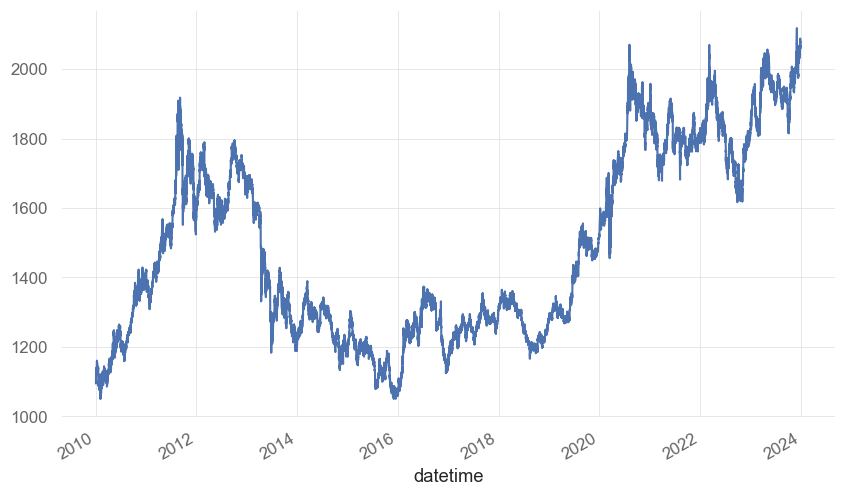

In [175]:
data['close'].plot()

In [176]:
# TIME FEATURES
features = data.copy()
features['returns'] = remove_outliers(features['close'].pct_change(fill_method=None).fillna(1e-6))

# Extracting time components
data_hour = features.index.hour
data_day_of_week = features.index.dayofweek
data_day_of_month = features.index.day
data_month = features.index.month

# Converting to cyclic features using sine and cosine transformations
features['hour_sin'] = np.sin(2 * np.pi * data_hour / 24)
features['hour_cos'] = np.cos(2 * np.pi * data_hour / 24)
features['day_of_week_sin'] = np.sin(2 * np.pi * data_day_of_week / 7)
features['day_of_week_cos'] = np.cos(2 * np.pi * data_day_of_week / 7)
features['day_of_month_sin'] = np.sin(2 * np.pi * data_day_of_month / 31)
features['day_of_month_cos'] = np.cos(2 * np.pi * data_day_of_month / 31)
features['month_sin'] = np.sin(2 * np.pi * data_month / 12)
features['month_cos'] = np.cos(2 * np.pi * data_month / 12)

In [177]:
# INDICATORS, NORMALIZED
ATR = ta.atr(features['high'], features['low'], features['close'], 14)
EMA_FAST = ta.ema(features['close'], 7)
EMA_SLOW = ta.ema(features['close'], 35)
RSI = ta.rsi(features['close'], 14)

In [178]:
# INDICATOR : HAWKES PROCESS
returns_norm = features['returns']
atr_norm = (features['high'] - features['low'] ) / ATR
volume_change_norm = normalize_data(features['volume'].pct_change(fill_method=None).fillna(1e-6))

# Apply the Hawkes process to the 'close' column
features['hawkes_returns'] = hawkes_process(returns_norm).fillna(0)
features['hawkes_volatility'] = hawkes_process(atr_norm).fillna(0)
features['hawkes_volume'] = hawkes_process(volume_change_norm).fillna(0)

In [179]:
# INDICATOR : SUPER OSCILLATOR
oscillator_results = super_oscillator(features)
features['suposc_oscillator'] = oscillator_results[0]
features['suposc_ama'] = oscillator_results[1]
features['suposc_histogram'] = oscillator_results[2]

In [180]:
# INDICATOR : DISTANCES FROM PIVOT POINTS
features_added = pivot_distances(features, 5, 5)
features = features_added.set_index('datetime', drop=True, append=False)
features.index = pd.to_datetime(features.index)

## PRE-STEP : MODEL TRAINING

In [181]:
# Feature Engineering
features['returns'] = features['close'].pct_change(fill_method=None).fillna(1e-6)

# Prepare the training data
train_daterange = pd.date_range('2001-01-01', '2021-12-31', freq='1h ')
train_df = features[features.index.isin(train_daterange)]
test_df = features[(features.index.year > train_daterange[-1].year)]
train_data = np.array(train_df['returns'])

In [182]:
# Parameters
n_pivots=3
n_clusters = 24
n_lookback=15
hold_period=3

miner = Miner(
    n_pivots=n_pivots,
    n_clusters=n_clusters,
    n_lookback=n_lookback,
    hold_period=hold_period,
    model_type='sequential',
    reducer='Wavelet',
)

# Fit the model
miner.fit(train_data, np.array(train_df['close']))

4.7621898342899325


In [183]:
features['cluster_labels'] = miner.transform(features['close']).astype(int)
train_df = features[features.index.isin(train_daterange)]
test_df = features[(features.index.year > train_daterange[-1].year)]

## STEP ONE : CLUSTER SELECTION AND COMBINATION

For this experiment, we would select the clusters that beat a benchmark (Buy-and-Hold)
- Profit Factor : 1
- Sharpe ratio : 0
- Ulcer Performance Index : 1
- Average Drawdown : From base data

If no cluster beats the Buy-and-Hold benchmark, we abandon the strategy

In [184]:
# Define the benchmarks / baseline
baseline_returns = train_df['returns']
baseline_profit_factor = max(qt.stats.profit_factor(baseline_returns), 1)
baseline_sharpe_ratio = max(qt.stats.sharpe(baseline_returns), 0)
baseline_upi = max(qt.stats.ulcer_performance_index(baseline_returns), 1)
baseline_max_dd = qt.stats.max_drawdown(baseline_returns) 

In [185]:
# Filter clusters per performance
selected_long = []
selected_short = []

combined = []

# For each cluster label
for cluster_label in range(n_clusters):
    _signals :np.ndarray = miner.apply_holding_period(train_df['cluster_labels'], selected_labels=[cluster_label])
    _signals = _signals != -1
    _signals = _signals.astype(int)

    # Test the returns as a Long and Short model
    for direction in [1, -1]:
        model_name = f"label_{cluster_label}_{'long' if direction > 0 else 'short'}"
        
        # Compute the returns
        _ret = train_df['returns'] * _signals * direction

        # Compute the kpis
        _pf = qt.stats.profit_factor(_ret)
        _sharpe = qt.stats.rolling_sharpe(_ret).mean()
        _upi = qt.stats.ulcer_performance_index(_ret)
        _max_dd = qt.stats.to_drawdown_series(_ret).mean()

        # Append results
        if ((_pf > baseline_profit_factor) and
            (_sharpe > baseline_sharpe_ratio) and
            (_upi > baseline_upi) and 
            (_max_dd > baseline_max_dd)):

            if direction > 0:
                selected_long.append(cluster_label)
                combined.append(_ret)

            else:
                selected_short.append(cluster_label)
                combined.append(_ret)

selected_long, selected_short

([2, 10], [])

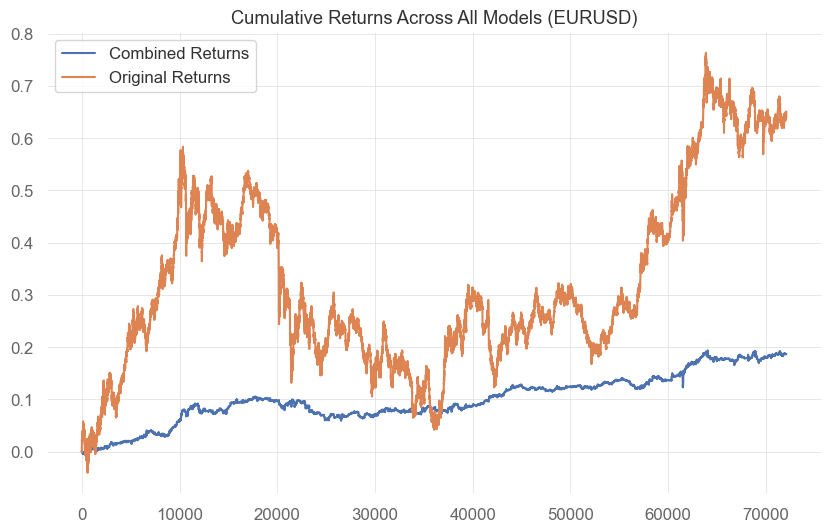

In [186]:
arr_combined = np.array(combined)
if arr_combined.size != 0:  # Check if reshort is not empty
    arr_combined = np.sum(arr_combined, axis=0) / arr_combined.shape[0]  # Dynamic division by the actual number of models
    plt.plot(np.cumsum(arr_combined), label='Combined Returns')
    plt.plot(np.cumsum(np.array(train_df['returns'])), label='Original Returns')
    plt.legend()
    plt.title('Cumulative Returns Across All Models (EURUSD)')
    plt.show()

                           Strategy
-------------------------  ----------
Start Period               2010-01-03
End Period                 2021-12-31
Risk-Free Rate             0.0%
Time in Market             9.0%

Cumulative Return          20.09%
CAGR﹪                     1.06%

Sharpe                     0.14
Prob. Sharpe Ratio         98.88%
Smart Sharpe               0.13
Sortino                    0.19
Smart Sortino              0.19
Sortino/√2                 0.14
Smart Sortino/√2           0.14
Omega                      1.1

Max Drawdown               -4.58%
Longest DD Days            1483
Volatility (ann.)          0.48%
Calmar                     0.23
Skew                       -0.21
Kurtosis                   217.89

Expected Daily %           0.0%
Expected Monthly %         0.13%
Expected Yearly %          1.54%
Kelly Criterion            4.55%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.05%
Expected Shortfall (cVaR)  -0.05%

Max Consecutive Wins       4


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2012-11-15,2014-04-30,2016-12-07,1483,-4.577075,-4.300015
2,2020-03-02,2020-03-13,2020-03-18,17,-3.002505,-2.630521
3,2020-08-19,2021-02-04,2021-12-31,499,-2.768578,-2.229182
4,2019-02-25,2019-05-30,2019-09-04,191,-2.078921,-2.017686
5,2011-12-02,2012-03-11,2012-06-20,202,-2.023824,-1.993142


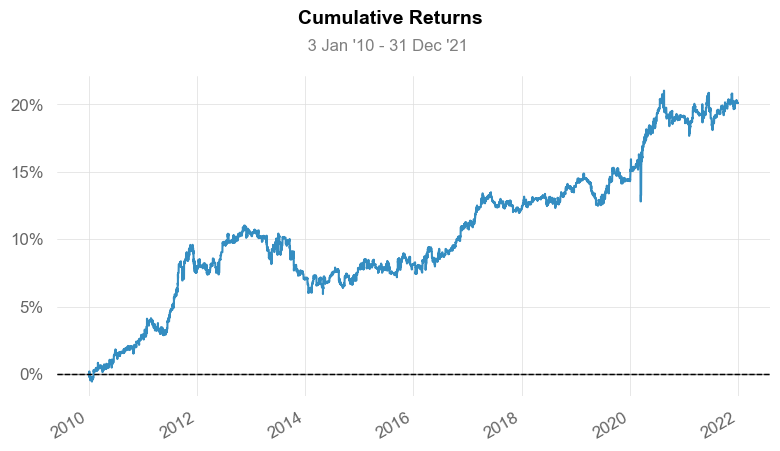

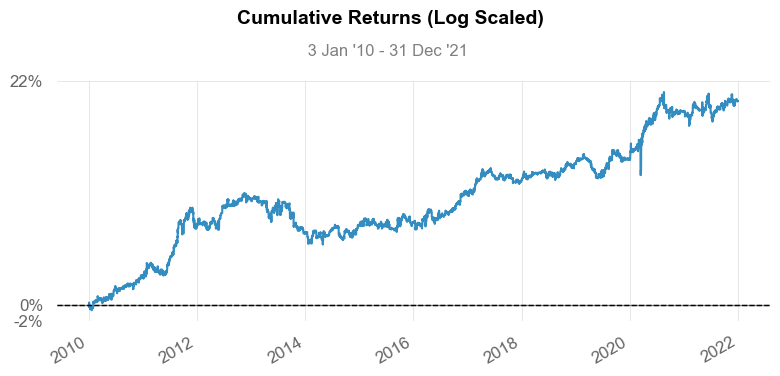

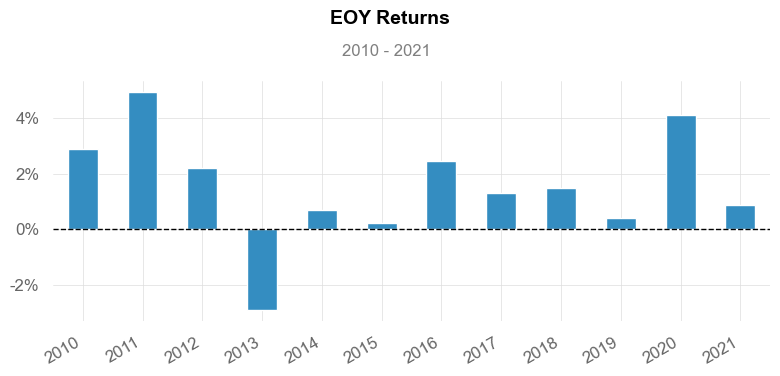

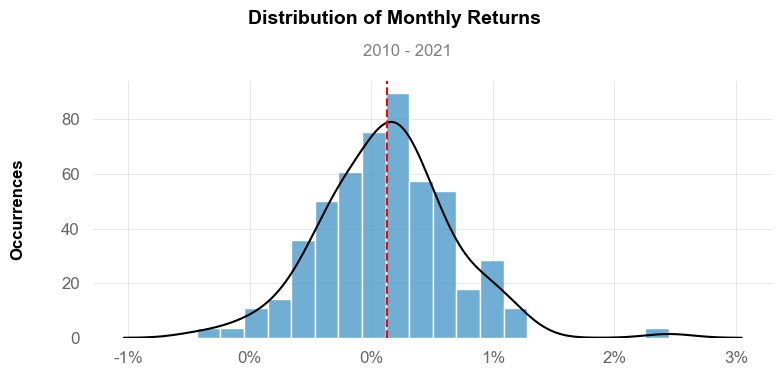

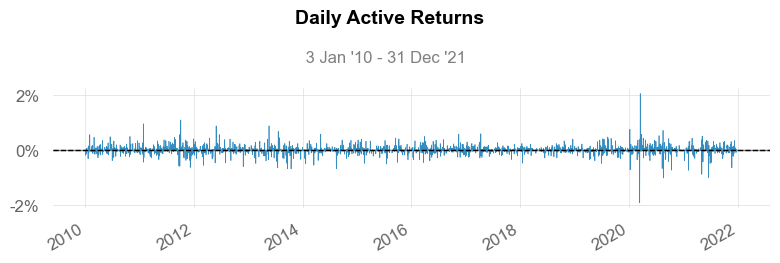

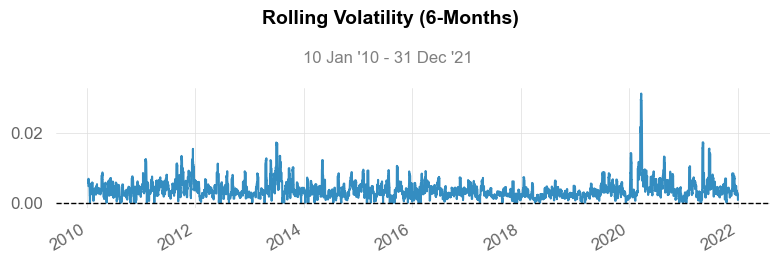

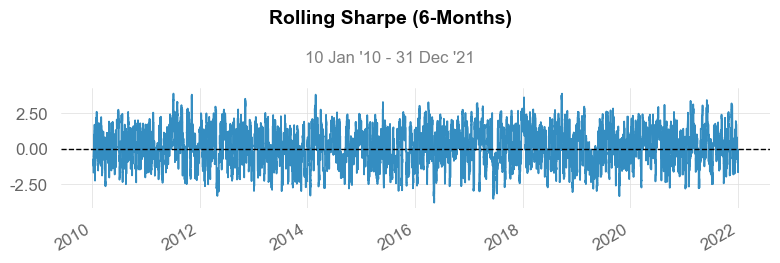

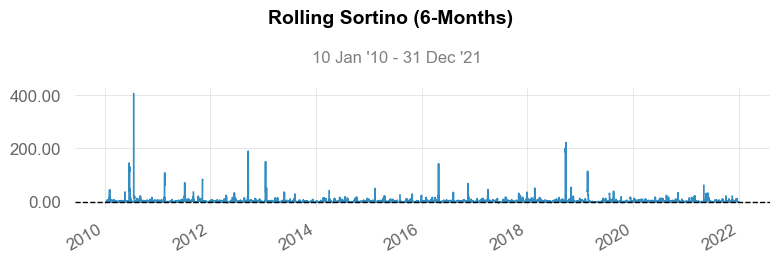

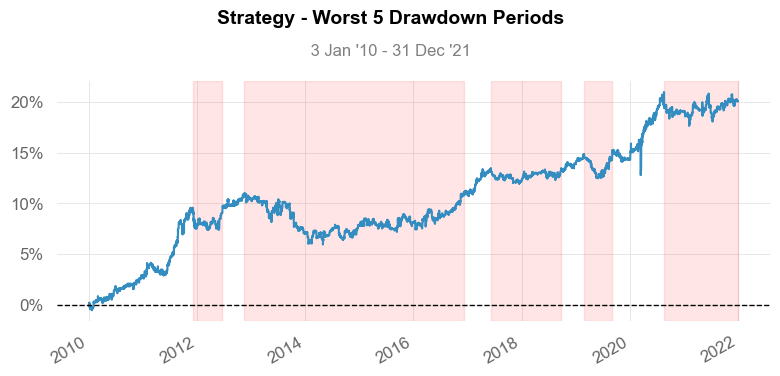

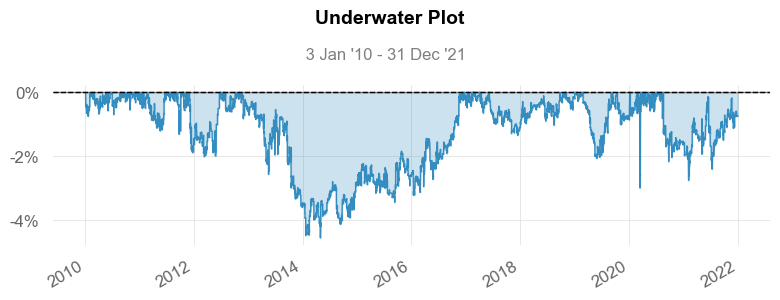

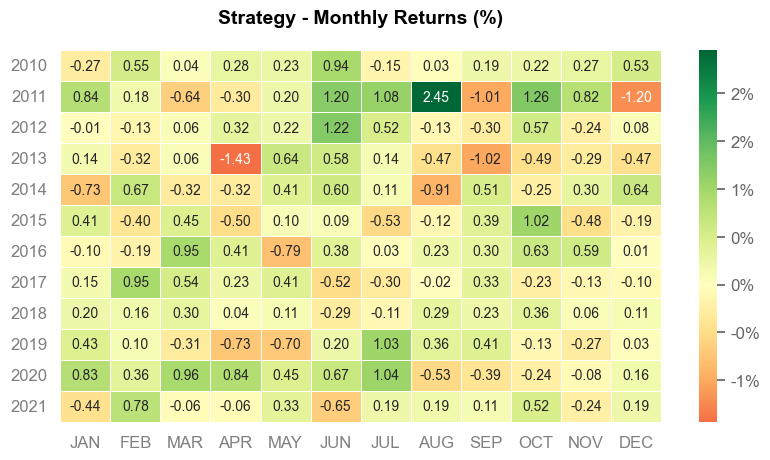

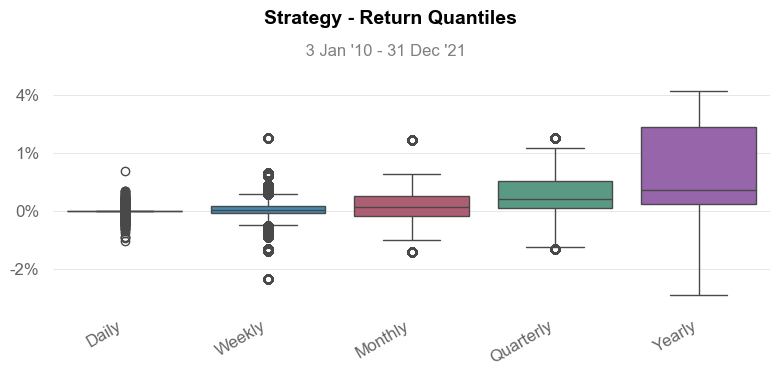

In [187]:
dff = train_df.copy()
dff['new'] = arr_combined
 
qt.reports.full((dff['new']))

In [188]:
corr_df = pd.DataFrame({f"strategy_{i}" : combined[i] for i in range(len(combined))})

# Calculating the correlation matrix
correlation_matrix = corr_df.corr()
correlation_matrix

,strategy_0,strategy_1
strategy_0,1.000000,0.036418
strategy_1,0.036418,1.000000


In [189]:
# import plotly.graph_objects as go

# # Fixed Parameters
# fig_base = go.Figure()
# for _ in range(n_clusters):
#     if _ not in set(selected_long + selected_short):
#         continue

#     _signals = miner.apply_holding_period(features['cluster_labels'], selected_labels=[_])
#     _signals = np.where(_signals != -1, 1, 0)
#     _ret = features['returns'] * _signals

#     _cumsum = np.cumsum(_ret)
#     fig_base.add_trace(go.Scatter(x=_cumsum.index, y=_cumsum, mode='lines', name=f' Clusters {_}'))

# fig_base.update_layout(title='Cluster Returns Over Time',
#                   xaxis_title='Time',
#                   yaxis_title='Cumulative Returns',
#                   legend_title='Clusters',
#                   hovermode='closest',
#                   )

# fig_base.show()

## STEP TWO : SIGNAL REFINING

For this step, we would attempt to refine the strategy signals, using the features and a ML model.
- Using the features, we would train an XGBoost Model to classify trades that 'could' lead to profit

In [190]:
# refine_df = train_df.copy().reset_index()

In [191]:
# # Compute the Y for each clusters; 1 for profit; 0 for loss
# Y_long = np.zeros(refine_df.shape[0])
# Y_short = np.zeros(refine_df.shape[0])

# long_indices = np.where(np.isin(refine_df['cluster_labels'], selected_long))[0]
# short_indices = np.where(np.isin(refine_df['cluster_labels'], selected_short))[0]

# for index in long_indices:
#     # Get the next [hold_period] array of returns
#     start_index = index + 1
#     end_index = index + hold_period
    
#     _ret = refine_df.loc[start_index:end_index, 'returns']
    
#     signal = int(np.sign(np.sum(_ret)) > 0)
#     Y_long[index] = signal

# for index in short_indices:
#     # Get the next [hold_period] array of returns
#     start_index = index + 1
#     end_index = index + hold_period
    
#     _ret = refine_df.loc[start_index:end_index, 'returns'] * -1
    
#     signal = int(np.sign(np.sum(_ret)) > 0)
#     Y_short[index] = signal

# Y = np.logical_or(Y_long, Y_short).astype(int)
# refine_df['Y'] = Y

In [192]:
# refine_df.columns

In [193]:
# refine_df[(np.isin(refine_df['cluster_labels'], selected_long)) | (np.isin(refine_df['cluster_labels'], selected_short))].shape

In [194]:
# import pandas as pd
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Sample DataFrame loading
# # df = pd.read_csv('your_data.csv')  # Uncomment and modify this line to load your data

# # Assume 'Y' is the target variable column
# selected_data = refine_df[(np.isin(refine_df['cluster_labels'], selected_long)) | (np.isin(refine_df['cluster_labels'], selected_short))]
# X = selected_data.drop(['datetime', 'open', 'high', 'low', 'close', 'volume', 'Y', 'returns'], axis=1)
# y = selected_data['Y']

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Instantiate an XGBoost classifier object
# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# # Train the classifier
# xgb_clf.fit(X_train, y_train)

# # Predictions
# y_pred = xgb_clf.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')

# # If you need to make predictions on new data:
# # new_data_predictions = xgb_clf.predict(new_data)